# Test of PS_Fullmodel_2step by LBNL (Slimming level 1)

Setteing of circuits

In [10]:
import warnings
warnings.simplefilter('ignore')

In [11]:
from sample_algorithm.twostepSim_LBNL import runQuantum
circuit_LBNL1 = runQuantum(gLR=1,dophisplit=1)

In [12]:
from transpiler.optimization import slim
example1 = slim.circuit_optimization( circuit = circuit_LBNL1 , slim_level = 1, cut = ['low',None], work_register = 'w')
circuit_LBNL1_op = example1.slim()
circuit_LBNL1 = runQuantum(gLR=1,dophisplit=1)

In [13]:
from qiskit import(
  QuantumCircuit,
  execute,
  Aer)
from qiskit.visualization import plot_histogram

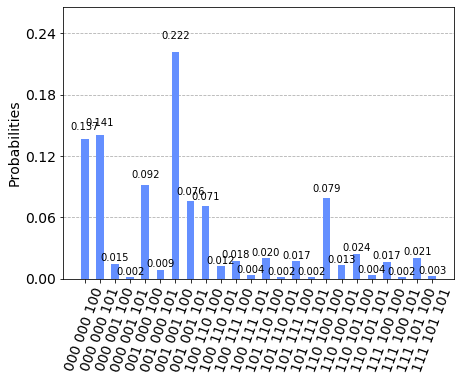

In [14]:
circuit=circuit_LBNL1
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots=2000)
result = job.result()
counts = result.get_counts(circuit)

plot_histogram(counts,number_to_keep=None)

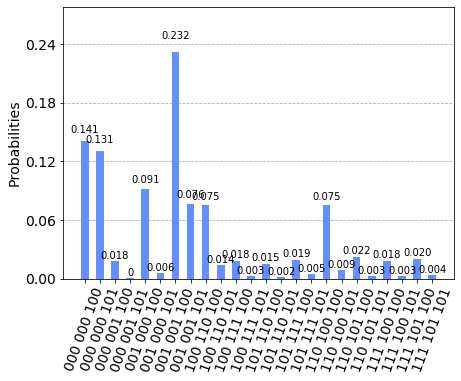

In [15]:
circuit=circuit_LBNL1_op
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots=2000)
result = job.result()
counts = result.get_counts(circuit)

plot_histogram(counts,number_to_keep=None)

## New Optimizer vs Qiskit

### Before slimming

In [16]:
print(circuit_LBNL1.depth(), ',', circuit_LBNL1.__len__())
print('Gate counts:', circuit_LBNL1.count_ops())

108 , 158
Gate counts: OrderedDict([('ccx', 74), ('x', 45), ('cu3', 19), ('cx', 10), ('measure', 9), ('barrier', 1)])


In [17]:
print(circuit_LBNL1.num_qubits)

24


In [18]:
circuit_LBNL1_basis = circuit_LBNL1.decompose()
print(circuit_LBNL1_basis.depth(), ',', circuit_LBNL1_basis.__len__())
print('Gate counts:', circuit_LBNL1_basis.count_ops())

770 , 1289
Gate counts: OrderedDict([('cx', 492), ('t', 296), ('tdg', 222), ('h', 148), ('u3', 83), ('u1', 38), ('measure', 9), ('barrier', 1)])


### After slimming

In [19]:
print(circuit_LBNL1_op.depth(), ',', circuit_LBNL1_op.__len__())
print('Gate counts:', circuit_LBNL1_op.count_ops())

95 , 132
Gate counts: OrderedDict([('cx', 46), ('ccx', 30), ('x', 27), ('cry', 17), ('measure', 9), ('ry', 2), ('barrier', 1)])


In [20]:
print(circuit_LBNL1_op.num_qubits)

21


In [21]:
circuit_LBNL1_op_basis = circuit_LBNL1_op.decompose()
print(circuit_LBNL1_op_basis.depth(), ',', circuit_LBNL1_op_basis.__len__())
print('Gate counts:', circuit_LBNL1_op_basis.count_ops())

379 , 603
Gate counts: OrderedDict([('cx', 260), ('t', 120), ('tdg', 90), ('u3', 61), ('h', 60), ('measure', 9), ('r', 2), ('barrier', 1)])


## New Optimizer vs tket

In [22]:
from pytket.qiskit import qiskit_to_tk, tk_to_qiskit
from pytket.passes import (RemoveRedundancies, CommuteThroughMultis, CliffordSimp, RebaseIBM, O2Pass,
                           FullPeepholeOptimise, EulerAngleReduction, USquashIBM, SynthesiseIBM, PauliSimp,
                           GuidedPauliSimp, OptimisePhaseGadgets, SquashHQS, FlattenRegisters, KAKDecomposition,
                           RepeatPass, SequencePass)
from pytket import OpType

### Before slimming

In [23]:
def passes2(circ_tk):
    pass_list=[EulerAngleReduction(OpType.Rz, OpType.Rx),
    RemoveRedundancies(),
    GuidedPauliSimp(),
    SquashHQS(),
    FlattenRegisters(),
    OptimisePhaseGadgets(),
    KAKDecomposition(),
    USquashIBM(),
    CliffordSimp(),
    FullPeepholeOptimise()]
    
    RebaseIBM().apply(circ_tk)
    CommuteThroughMultis().apply(circ_tk)
    
    circ_tk_qiskit_copy = tk_to_qiskit(circ_tk)
    circ_tk_copy = qiskit_to_tk(circ_tk_qiskit_copy)
    
    best_pass = RebaseIBM()
    mini = tk_to_qiskit(circ_tk).__len__()
    for a_pass in pass_list:
        #print(tk_to_qiskit(circ_tk_copy).__len__())
        a_pass.apply(circ_tk_copy)
        if circ_tk_copy.n_gates < mini :
            mini = circ_tk_copy.n_gates
            best_pass = a_pass
        circ_tk_qiskit_copy = tk_to_qiskit(circ_tk)
        circ_tk_copy = qiskit_to_tk(circ_tk_qiskit_copy)
        
    best_pass.apply(circ_tk)
        
    return circ_tk

In [ ]:
circ = circuit_LBNL1
mystate_reduct_tk = qiskit_to_tk(circ)
RebaseIBM().apply(mystate_reduct_tk)

while tk_to_qiskit(mystate_reduct_tk).__len__() != tk_to_qiskit(passes2(mystate_reduct_tk)).__len__() :
    mystate_reduct_tk = passes2(mystate_reduct_tk)

mystate_reduct_qiskit=tk_to_qiskit(mystate_reduct_tk)

In [ ]:
print(mystate_reduct_qiskit.num_qubits)

In [16]:
print(mystate_reduct_qiskit.depth(), ',', mystate_reduct_qiskit.__len__())
print('Gate counts:', mystate_reduct_qiskit.count_ops())

693 , 962
Gate counts: OrderedDict([('cx', 485), ('u1', 272), ('u3', 195), ('measure', 9), ('barrier', 1)])


### After slimming

In [17]:
circ = circuit_LBNL1_op
mystate_reduct_tk = qiskit_to_tk(circ)
RebaseIBM().apply(mystate_reduct_tk)

while tk_to_qiskit(mystate_reduct_tk).__len__() != tk_to_qiskit(passes2(mystate_reduct_tk)).__len__() :
    mystate_reduct_tk = passes2(mystate_reduct_tk)

mystate_reduct_qiskit_op=tk_to_qiskit(mystate_reduct_tk)

In [18]:
print(mystate_reduct_qiskit_op.num_qubits)

21


In [19]:
print(mystate_reduct_qiskit_op.depth(), ',', mystate_reduct_qiskit_op.__len__())
print('Gate counts:', mystate_reduct_qiskit_op.count_ops())

347 , 480
Gate counts: OrderedDict([('cx', 246), ('u3', 145), ('u1', 79), ('measure', 9), ('barrier', 1)])


# Conclusion
・qiskit+my_optimizer > qiskit
<br>
・tket+my_optimizer > tket

In [28]:
circ_list = [circuit_LBNL1_basis, mystate_reduct_qiskit, circuit_LBNL1_op_basis, mystate_reduct_qiskit_op]

In [29]:
depth_list = [circuit_LBNL1_basis.depth(), mystate_reduct_qiskit.depth(), circuit_LBNL1_op_basis.depth(),
             mystate_reduct_qiskit_op.depth()]

In [30]:
qubits_list = [circuit_LBNL1_basis.num_qubits, mystate_reduct_qiskit.num_qubits, circuit_LBNL1_op_basis.num_qubits,
             mystate_reduct_qiskit_op.num_qubits]

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
import matplotlib.cm as cm

color_list=[]
for key in colors.TABLEAU_COLORS:
    color_list.append(key)
print(color_list)

['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


[492, 787, 1279, 770]
[485, 467, 952, 693]
[260, 333, 593, 379]
[246, 224, 470, 347]


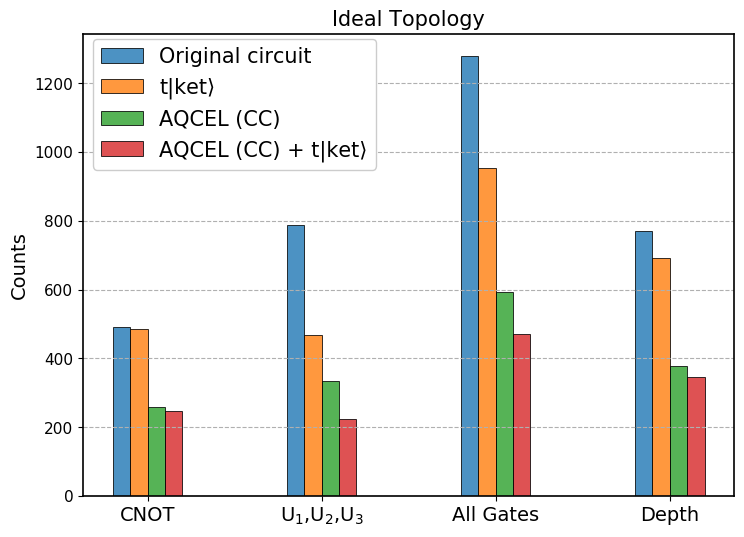

In [32]:
plt.style.use('default')

n = 4
index = np.arange(n)
bar_width = 0.1
alpha = 0.8
fig = plt.figure(figsize=(8.4, 6))
spines = 1.2

ax = fig.add_subplot(111)
ax.spines["top"].set_linewidth(spines)
ax.spines["left"].set_linewidth(spines)
ax.spines["bottom"].set_linewidth(spines)
ax.spines["right"].set_linewidth(spines)



name_list=['Original circuit','t|ket⟩','AQCEL (CC)','AQCEL (CC) + t|ket⟩']

for i,circ in enumerate(circ_list):
    native_gate_num =[0,0,0,depth_list[i]]
    for key,value in circ.count_ops().items():
        if key == 'cx':
            native_gate_num[0] += value
            native_gate_num[2] += value
        elif key != 'barrier' and key != 'measure':
            native_gate_num[1] += value
            native_gate_num[2] += value
            
    print(native_gate_num)
            
    plt.bar(index + i*bar_width, native_gate_num, bar_width, alpha=alpha ,label=name_list[i], color = color_list[i], linewidth=0.7, edgecolor="black")


plt.yticks(fontsize=11)
plt.title('Ideal Topology',fontsize=15)
plt.ylabel('Counts',fontsize=14)
plt.xticks(index + 1.5*bar_width, ('CNOT','U$_1$,U$_2$,U$_3$','All Gates','Depth'),fontsize=14)
plt.grid(axis = 'y',linestyle = "--")
plt.legend(bbox_to_anchor=(0.45, 0.99), loc='upper right', borderaxespad=0, fontsize=15, framealpha=1)
plt.show()
fig.savefig('prefig5_2step_gates.pdf',bbox_inches='tight', pad_inches=0.1)